Code for calculating the KL divergence between the amortized posterior (evoked activity) and the prior distribution (spontaneous activity).

In [2]:
import numpy as np
import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import os

# Generate samples and discretize

In [10]:
# let's first try to plot how a batch of datapoints are transformed by one modified forward process
from likelihood_utils import posterior_sample_loop_occlusion, reversed_forward_process_posterior_loop_occlusion
from generate_data import load_unimodal_data
from rad_utils import generate_2d_swiss_roll
from rad_utils import select_model

# select the model
prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)

# parameters for the likelihood
likelihood_sigma = 0.2
s=0.5
v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)

# sampling from the posterior distribution in a sequential manner
from likelihood_utils import sequential_posterior_sampler

num_samples_in_gt_manifold = 5e3
clean_manifold_t, data_roll_gt, min, max = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)

# initialize a random point on the ground truth manifold and start the sequential posterior sampling
# manifold_initial_point = data_roll_gt[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
manifold_initial_point = on_manifold_samples[-1]

num_cycles = 20000
num_steps = 100

on_manifold_samples, reverse_samples = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles, num_steps, burn=False)

print(reverse_samples.shape)  # should be (num_cycles, num_steps+1, 2)

z_rf = reverse_samples

embedding dimension is 2
model loaded!
the model has 34050 parameters
not burning


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 101, 2)


In [4]:
# saving the data
import zarr
# zarr.save('saved_arrays/reverse_samples_posterior_2e4_3.zarr', reverse_samples)
# zarr.save('saved_arrays/on_manifold_samples_posterior_2e4_3.zarr', on_manifold_samples)

# load later


In [8]:
# let's join the three arrays
reverse_samples_1 = zarr.load('saved_arrays/kl_divergence/reverse_samples_posterior_4e4_1.zarr')
reverse_samples_2 = zarr.load('saved_arrays/kl_divergence/reverse_samples_posterior_4e4_2.zarr')
reverse_samples_3 = zarr.load('saved_arrays/kl_divergence/reverse_samples_posterior_2e4_3.zarr')

print(reverse_samples_1.shape)
print(reverse_samples_2.shape)
print(reverse_samples_3.shape)
reverse_samples = np.concatenate((reverse_samples_1, reverse_samples_2, reverse_samples_3), axis=0)
print(reverse_samples.shape)
# zarr.save('saved_arrays/reverse_samples_posterior_1e5.zarr', reverse_samples)

z_rf = reverse_samples

(40000, 101, 2)
(40000, 101, 2)
(20000, 101, 2)
(100000, 101, 2)


99999.0


<AxesSubplot:>

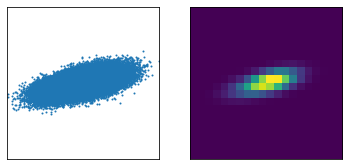

In [9]:
# turn the samples into a histogram

num_bins = 20
theta = 0  # temperature index / beta index

lim=3
bins = np.linspace(-lim, lim, num_bins+1)
z_rf_hist = np.histogram2d(z_rf[:, theta, 0], z_rf[:, theta, 1], bins=bins)[0]
print(np.sum(z_rf_hist))
# so the histogram is not normalized

# plot
fig, ax = plt.subplots(1, 2)
ax[0].scatter(*z_rf[:, theta].T, s=1)
ax[0].set(xlim=[-lim, lim], ylim=[-lim, lim])
ax[0].set_aspect('equal')
ax[1].imshow(z_rf_hist.T, origin='lower')

from rad_utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax[0])
remove_all_ticks_and_labels(ax[1])


(101, 20, 20)


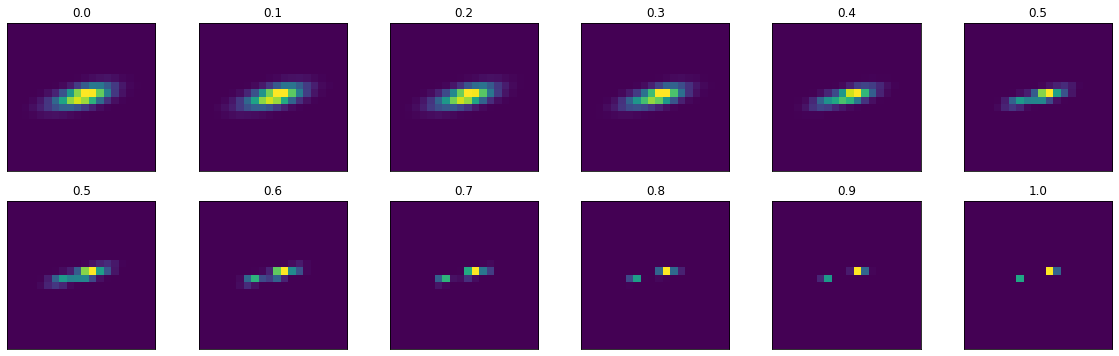

In [10]:
# now calculate the histogram for all thetas
from likelihood_utils import calculate_histogram_for_seq_data

histograms = calculate_histogram_for_seq_data(z_rf, num_bins=20, lim=3)
print(histograms.shape)

# plot the histograms of the posterior distributions as a function of beta (0 to 1)
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
idx0 = 0
idx1 = 0
for h, hist in enumerate(histograms):
    if h in [0, 10, 20, 30, 40, 50]:
        a = ax[0, idx0]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx0 += 1
    if h in [50, 60, 70, 80, 90, 100]:
        a = ax[1, idx1]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx1 += 1
        
save=False
if save:
    savedir = 'plots/neurips'
    figname = f'distribution-histograms-posterior.pdf'    
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

Let's now generate samples from diffusing onto the prior

## samples from prior diffusion

In [143]:
num_cycles = 100000

from rad_utils import sequential_prior_sampler
prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)

num_samples_in_gt_manifold = 5e3
clean_manifold_t, data_roll_gt, min, max = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)
manifold_initial_point = data_roll_gt[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)

prior_samples, prior_fwd_samples, prior_rev_samples = sequential_prior_sampler(prior_sampler, manifold_initial_point, num_cycles, num_steps)

print(prior_samples.shape)
print(prior_rev_samples.shape)

embedding dimension is 2
model loaded!
the model has 34050 parameters


  0%|          | 0/100000 [00:00<?, ?it/s]

(100000, 2)
(100000, 101, 2)


In [13]:
# save the prior samples

# zarr.save('saved_arrays/prior_samples_1e5.zarr', prior_samples)
# zarr.save('saved_arrays/prior_rev_samples_1e5.zarr', prior_rev_samples)

prior_rev_samples = zarr.load('saved_arrays/kl_divergence/prior_rev_samples_1e5.zarr')

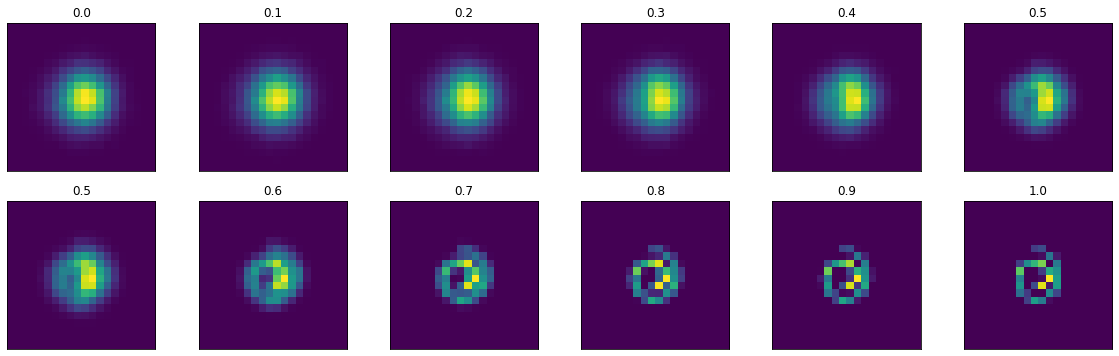

In [14]:
# now calculate and plot the histograms of the prior samples for all thetas
from likelihood_utils import calculate_histogram_for_seq_data

prior_histograms = calculate_histogram_for_seq_data(prior_rev_samples, num_bins=20, lim=3)

# plot 
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
idx0 = 0
idx1 = 0
for h, hist in enumerate(prior_histograms):
    if h in [0, 10, 20, 30, 40, 50]:
        a = ax[0, idx0]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx0 += 1
    if h in [50, 60, 70, 80, 90, 100]:
        a = ax[1, idx1]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx1 += 1

# biased estimator of KL divergence
using the naive plug-in estimator

### only calculate kl where p_i and q_i are not 0
i.e. KL(p || q) = 0 when p_i = 0 or q_i = 0

first show histograms of nonzero bins for one value of beta

In [15]:
def kl(p_i, q_i):
    return p_i * np.log(p_i / q_i)

# p = amortized posterior, q = prior
q_prior = prior_histograms[100]
q_prior = q_prior.flatten() / np.sum(q_prior)

kl_divergences_prior = []
num_non_zero_over_theta = []
theta = 100
p = histograms[theta].flatten() / np.sum(histograms[theta])

kl_one_theta = 0
num_non_zero = 0
for i, p_i in enumerate(p):
    q_i = q_prior[i]
    if p_i != 0 and q_i != 0:
        kl_one_dim = kl(p_i, q_i)
        kl_one_theta += kl_one_dim
        print(i, f'{p_i:2f}', f'{q_i:2f}', f'{kl_one_dim:3f}')
        num_non_zero += 1
num_non_zero_over_theta.append(num_non_zero/400)
kl_divergences_prior.append(kl_one_theta)

129 0.000790 0.000030 0.002584
148 0.000010 0.042190 -0.000083
149 0.308900 0.035950 0.664409
209 0.000310 0.002240 -0.000613
210 0.000090 0.013940 -0.000454
229 0.000060 0.081600 -0.000433
230 0.521650 0.050050 1.222734
250 0.168050 0.041320 0.235760


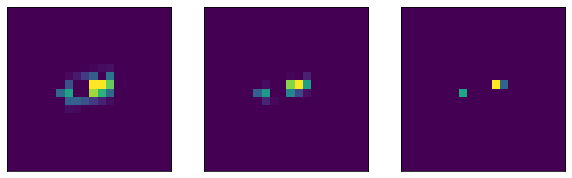

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

qq = prior_histograms[100].flatten()
h0 = histograms[0].flatten()
h50 = histograms[50].flatten()
h100 = histograms[100].flatten()

qq0 = qq.copy()
qq50 = qq.copy()
qq100 = qq.copy()
for q, _ in enumerate(qq):
    if qq[q] == 0 or h0[q] == 0:
        qq0[q] = 0
        h0[q] = 0
    if qq[q] == 0 or h50[q] == 0:
        qq50[q] = 0
        h50[q] = 0
    if qq[q] == 0 or h100[q] == 0:
        qq100[q] = 0
        h100[q] = 0

qq0 = qq0.reshape(20, 20)
qq50 = qq50.reshape(20, 20)
qq100 = qq100.reshape(20, 20)

h0 = h0.reshape(20, 20)
h50 = h50.reshape(20, 20)
h100 = h100.reshape(20, 20)

ax[0].imshow(h0.T, origin='lower')
ax[1].imshow(h50.T, origin='lower')
ax[2].imshow(h100.T, origin='lower')

for a in ax:
    remove_all_ticks_and_labels(a)

now calculate the kl divergence between the amortized posterior p and the prior q for all values of beta

In [17]:
def kl(p_i, q_i):
    return p_i * np.log(p_i / q_i)

# p = amortized posterior, q = prior
q_prior = prior_histograms[100]
q_prior = q_prior.flatten() / np.sum(q_prior)

kl_divergences_prior = []
num_non_zero_over_theta = []
for theta in range(len(prior_histograms)):
    p = histograms[theta].flatten() / np.sum(histograms[theta])

    kl_one_theta = 0
    num_non_zero = 0
    for i, p_i in enumerate(p):
        q_i = q_prior[i]
        if p_i != 0 and q_i != 0:
            kl_one_dim = kl(p_i, q_i)
            kl_one_theta += kl_one_dim
            num_non_zero += 1
    num_non_zero_over_theta.append(num_non_zero/400)
    kl_divergences_prior.append(kl_one_theta)
kl_divergences_prior = np.stack(kl_divergences_prior)



# p = amortized posterior, q = likelihood
q_llh = prior_histograms[0]
q_llh = q_llh.flatten() / np.sum(q_llh)

kl_divergences_llh = []
for theta in range(len(prior_histograms)):
    p = histograms[theta].flatten() / np.sum(histograms[theta])

    kl_one_theta = 0
    for i, p_i in enumerate(p):
        q_i = q_llh[i]
        if p_i != 0 and q_i != 0:
            kl_one_dim = kl(p_i, q_i)
            kl_one_theta += kl_one_dim

    kl_divergences_llh.append(kl_one_theta)
kl_divergences_llh = np.stack(kl_divergences_llh)

Text(0.5, 0.98, 'KL(amortized posterior || llh)')

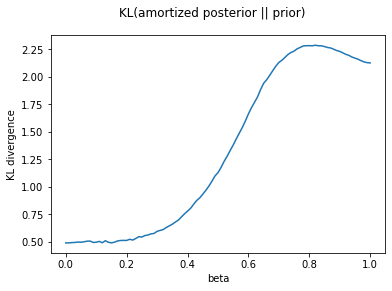

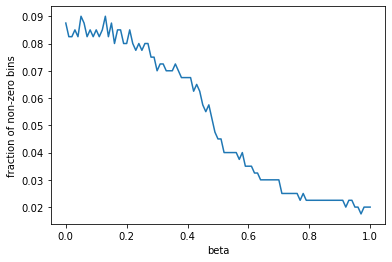

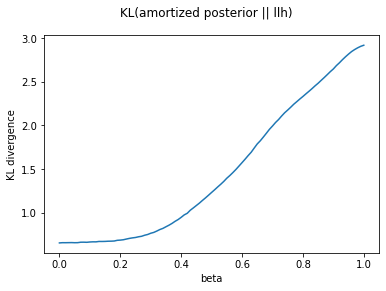

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0, 1.01, 0.01), kl_divergences_prior)
ax.set(xlabel='beta', ylabel='KL divergence')
fig.suptitle('KL(amortized posterior || prior)')

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0, 1.01, 0.01), num_non_zero_over_theta)
ax.set(xlabel='beta', ylabel='fraction of non-zero bins')

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0, 1.01, 0.01), kl_divergences_llh)
ax.set(xlabel='beta', ylabel='KL divergence')
fig.suptitle('KL(amortized posterior || llh)')


instead of decreasing with beta, the kl divergence `KL(amortized posterior || prior)` increases with beta, suggesting that the amortized posterior is closest to the prior at the start of the cycle when the reverse process is dominated by the effect of the likelihood rather than the prior.

this is weird but can be accounted for by the way we calculate the kl divergence using only the nonzero bins — when beta is 1 the nonzero bins over which we do the calculation is determined mostly by the shape of the posterior. since the posterior puts all of its probability mass on those points, the value of p_i (the mass in that bin) will be on average larger than q_i, and most of the kl terms from each bin will be positive. in contrast, when beta is 0, the nonzero bins over which we do the kl div calculation is determined mostly by the shape of the prior rather than the posterior; in this case, q_i will be on average larger than p_i and there will be more negative kl terms, pushing down the value of the total kl divergence.

let's try running the KL the other direction, where p is the prior and q is the amortized posterior. 

### other direction (p = prior, q  = posterior)

In [19]:
def kl(p_i, q_i):
    return p_i * np.log(p_i / q_i)

# p = prior, q = amortized posterior
p_prior = prior_histograms[100]
p_prior = p_prior.flatten() / np.sum(p_prior)

kl_divergences_opposite = []
num_non_zero_over_theta = []
for theta in range(len(prior_histograms)):
    q = histograms[theta].flatten() / np.sum(histograms[theta])

    kl_one_theta = 0
    num_non_zero = 0
    for i, q_i in enumerate(q):
        p_i = p_prior[i]
        if p_i != 0 and q_i != 0:
            kl_one_dim = kl(p_i, q_i)
            kl_one_theta += kl_one_dim
            num_non_zero += 1
    num_non_zero_over_theta.append(num_non_zero/400)
    kl_divergences_opposite.append(kl_one_theta)
kl_divergences_opposite = np.stack(kl_divergences_opposite)

[Text(0.5, 1.0, 'symmetric KL')]

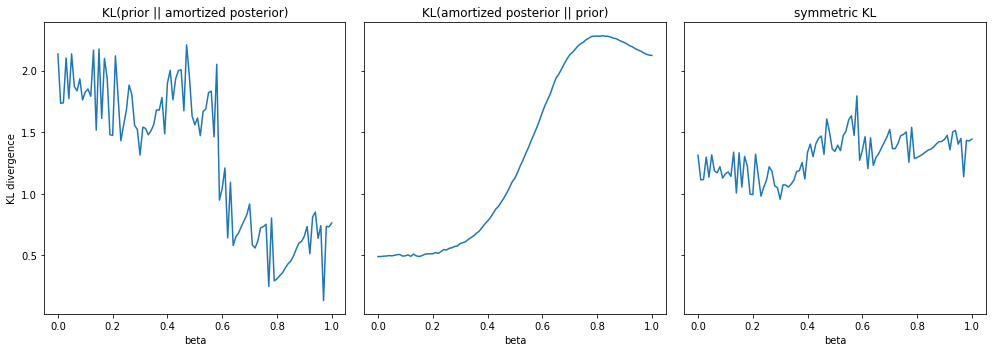

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
ax[0].plot(np.arange(0, 1.01, 0.01), kl_divergences_opposite)
ax[0].set(xlabel='beta', ylabel='KL divergence')
ax[0].set(title='KL(prior || amortized posterior)')

ax[1].plot(np.arange(0, 1.01, 0.01), kl_divergences_prior)
ax[1].set(xlabel='beta', ) 
ax[1].set(title='KL(amortized posterior || prior)')

fig.tight_layout()


# calculate the symmetric version:
kl_symmetric = 0.5* (kl_divergences_prior + kl_divergences_opposite)
ax[2].plot(np.arange(0, 1.01, 0.01), kl_symmetric)
ax[2].set(xlabel='beta')
ax[2].set(title='symmetric KL')


### THe other 'naive' way -- by putting a small epsilon in the bins that have 0 samples 

In [21]:
# calculate the KL divergence between the distributions
from scipy.stats import entropy

epsilon = 1e-5  # I can't compute KL divergence when there are 0s. So I need to add a small value to each bin
# epsilon = 0.1  # I can't compute KL divergence when there are 0s. So I need to add a small value to each bin

p = histograms[1] + epsilon  # test dist
q = histograms[0] + epsilon  # dist to compare to

p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
q = q.flatten() / np.sum(q)

print(entropy(p, q))

0.0011925005739883438


In [22]:
q_llh = histograms[0] + epsilon  # dist to compare to
q_llh = q_llh.flatten() / np.sum(q_llh)

entropies_llh = []
for phi in range(len(histograms)):
    p = histograms[phi] + epsilon  # test dist
    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    entropies_llh.append(entropy(p, q_llh))
    
entropies_llh = np.stack(entropies_llh)


# q_post = histograms[100] + epsilon  # dist to compare to
# q_post = q_post.flatten() / np.sum(q_post)

# entropies_post = []
# for phi in range(len(histograms)):
#     p = histograms[phi] + epsilon  # test dist
#     p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
#     entropies_post.append(entropy(p, q_post))
# entropies_post = np.stack(entropies_post)


q_prior = prior_histograms[100] + epsilon  # dist to compare to
q_prior = q_prior.flatten() / np.sum(q_prior)

entropies_prior = []
for phi in range(len(prior_histograms)):
    # p = prior_histograms[phi] + epsilon  # test dist
    p = histograms[phi] + epsilon  # test dist
    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    entropies_prior.append(entropy(p, q_prior))
entropies_prior = np.stack(entropies_prior)

plot the KL divergence between the amortized posterior and the likelihood, posterior, and prior distributions

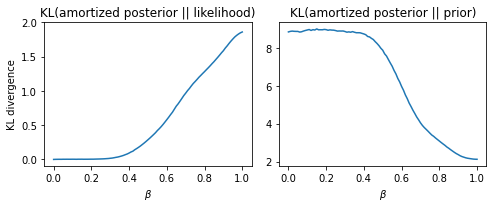

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].plot(np.linspace(0, 1, len(entropies_llh)), entropies_llh)
ax[0].set(title='KL(amortized posterior || likelihood)', ylabel='KL divergence', xlabel='$\\beta$')
ax[0].set(yticks=[0, 0.5, 1, 1.5, 2])

ax[1].set(title='KL(amortized posterior || prior)', xlabel='$\\beta$')
ax[1].plot(np.linspace(0, 1, len(entropies_prior)), entropies_prior)


# ax[2].plot(np.linspace(0, 1, len(entropies_post)), entropies_post)
# ax[2].set(title='KL( amortized posterior || posterior )', ylabel='KL divergence', xlabel='$\\beta$')
fig.tight_layout()

save=True
if save:
    savedir = 'plots/neurips'
    figname = f'kl-divergences.pdf'    
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

How does the estimate of the KL divergence change as a function of the sample size?

In [62]:
# prior_rev_samples = zarr.load('saved_arrays/prior_rev_samples_10000.zarr')

def generate_histograms(reverse_samples, prior_rev_samples, num_samples=100000, step_size=10000, ):
    prior_samples_by_size = [prior_rev_samples[:i, 100] for i in range(step_size, num_samples+1, step_size)]
    posterior_rev_samples_by_size = [reverse_samples[:i] for i in range(step_size, num_samples+1, step_size)]

    prior_histograms_by_sample_size = []
    for j in range(len(prior_samples_by_size)):
        # print(j, prior_samples_by_size[j].shape)
        prior_histogram_100 = np.histogram2d(*prior_samples_by_size[j].T, bins=20, range=[[-3, 3], [-3, 3]])[0]  # shape=(num_samples, 20, 20)
        prior_histograms_by_sample_size.append(prior_histogram_100)
    prior_histograms_by_sample_size = np.stack(prior_histograms_by_sample_size)

    posterior_histograms_by_sample_size = []
    for j in range(len(posterior_rev_samples_by_size)):
        # print(j, posterior_rev_samples_by_size[j].shape)
        posterior_histograms_all_thetas = calculate_histogram_for_seq_data(posterior_rev_samples_by_size[j], num_bins=20, lim=3)  # shape=(101, 20, 20)
        posterior_histograms_by_sample_size.append(posterior_histograms_all_thetas)
    posterior_histograms_by_sample_size = np.stack(posterior_histograms_by_sample_size)

    print(prior_histograms_by_sample_size.shape)
    print(posterior_histograms_by_sample_size.shape)
    
    return prior_histograms_by_sample_size, posterior_histograms_by_sample_size

prior_histograms_by_sample_size, posterior_histograms_by_sample_size = generate_histograms(reverse_samples, prior_rev_samples)

(10, 20, 20)
(10, 101, 20, 20)


In [72]:
# calculate the KL divergence between the distributions for each sample size
from scipy.stats import entropy
epsilon = 1e-14  # I can't compute KL divergence when there are 0s. So I need to add a small value to each bin

def kl_divergence_using_plugin_estimator(prior_histograms_by_sample_size, posterior_histograms_by_sample_size, epsilon):
    prior_histograms = prior_histograms_by_sample_size + epsilon
    posterior_histograms = posterior_histograms_by_sample_size + epsilon

    kl_by_sample_size_all_temps = []
    for sample_size_idx in range(len(prior_histograms)):
        # calculate the KL divergence between the distributions for each temperature
        kl_by_temp_one_sample_size = []
        for theta_idx in range(len(posterior_histograms[0])):
            p = posterior_histograms[sample_size_idx][theta_idx].flatten() / np.sum(posterior_histograms[sample_size_idx][theta_idx])  # turn into a vector and then normalize
            q = prior_histograms[sample_size_idx].flatten() / np.sum(prior_histograms[sample_size_idx])
            kl_div = entropy(p, q)
            kl_by_temp_one_sample_size.append(kl_div)
        kl_by_temp_one_sample_size = np.stack(kl_by_temp_one_sample_size)
        kl_by_sample_size_all_temps.append(kl_by_temp_one_sample_size)
    kl_by_sample_size_all_temps = np.stack(kl_by_sample_size_all_temps)

    print(kl_by_sample_size_all_temps.shape)  # (num_sample_sizes, num_temps)
    
    return kl_by_sample_size_all_temps

epsilon = 1e-14
kl_by_epsilon = {}
kl_by_epsilon['1e-14'] = kl_divergence_using_plugin_estimator(prior_histograms_by_sample_size, posterior_histograms_by_sample_size, epsilon)
epsilon = 1e-10
kl_by_epsilon['1e-10'] = kl_divergence_using_plugin_estimator(prior_histograms_by_sample_size, posterior_histograms_by_sample_size, epsilon)
epsilon = 1e-5
kl_by_epsilon['1e-5'] = kl_divergence_using_plugin_estimator(prior_histograms_by_sample_size, posterior_histograms_by_sample_size, epsilon)
epsilon = 1e-2
kl_by_epsilon['1e-2'] = kl_divergence_using_plugin_estimator(prior_histograms_by_sample_size, posterior_histograms_by_sample_size, epsilon)

(10, 101)
(10, 101)
(10, 101)
(10, 101)


1e-14
1e-10
1e-5
1e-2


Text(0.5, 0.98, 'epsilon = 1e-14')

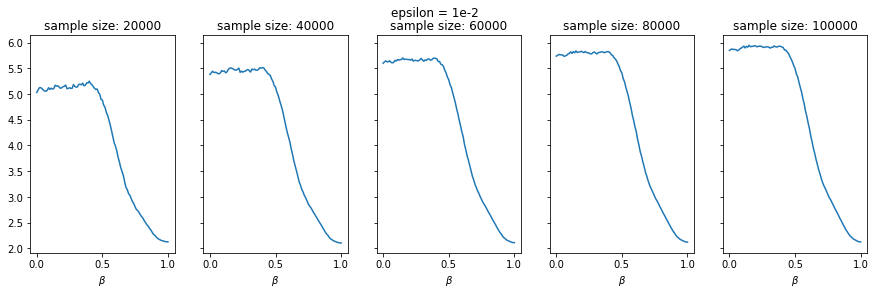

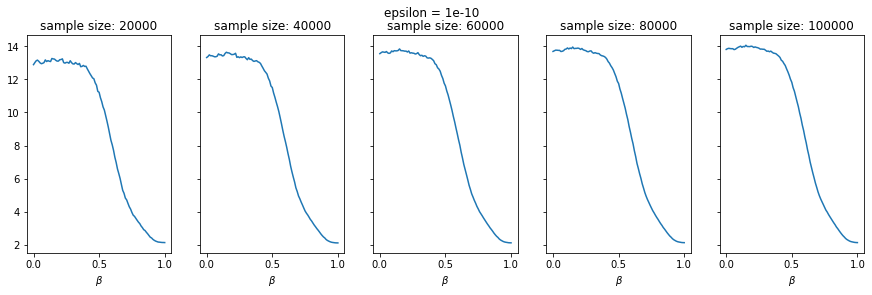

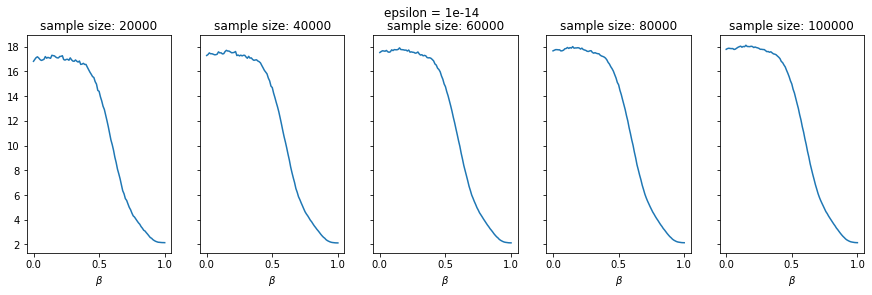

In [81]:
for key, value in kl_by_epsilon.items():
    print(key)


fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
sample_sizes = range(10000, 100001, 10000)
kl_by_sample_size_all_temps = kl_by_epsilon['1e-2']
for i in range(5):
    idx = i*2+1
    sample_size = sample_sizes[idx]
    ax[i].plot(np.linspace(0, 1, len(kl_by_sample_size_all_temps[0])), kl_by_sample_size_all_temps[idx, :])
    ax[i].set(title=f'sample size: {sample_size}')
    ax[i].set(xlabel='$\\beta$')
fig.suptitle('epsilon = 1e-2')
    

fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
sample_sizes = range(10000, 100001, 10000)
kl_by_sample_size_all_temps = kl_by_epsilon['1e-10']
for i in range(5):
    idx = i*2+1
    sample_size = sample_sizes[idx]
    ax[i].plot(np.linspace(0, 1, len(kl_by_sample_size_all_temps[0])), kl_by_sample_size_all_temps[idx, :])
    ax[i].set(title=f'sample size: {sample_size}')
    ax[i].set(xlabel='$\\beta$')
fig.suptitle('epsilon = 1e-10')


fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
sample_sizes = range(10000, 100001, 10000)
kl_by_sample_size_all_temps = kl_by_epsilon['1e-14']
for i in range(5):
    idx = i*2+1
    sample_size = sample_sizes[idx]
    ax[i].plot(np.linspace(0, 1, len(kl_by_sample_size_all_temps[0])), kl_by_sample_size_all_temps[idx, :])
    ax[i].set(title=f'sample size: {sample_size}')
    ax[i].set(xlabel='$\\beta$')
fig.suptitle('epsilon = 1e-14')

# unbiased estimator of the KL divergence (NSB)

The above KL divergence measures are biased. We can instead use the NSB estimator.

K: 400
N: 1000.0
150
150
NSB estimate of the entropy: 3.502062248613554


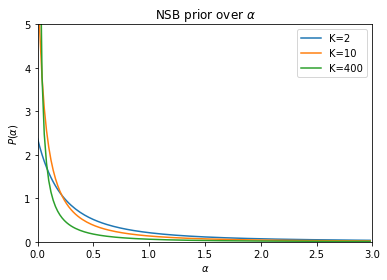

In [ ]:
# NSB estimator
from scipy.special import digamma, polygamma

phi = 0
n = histograms_reshaped[phi, :]
K = n.shape[0]
alphas = np.arange(0, 3.0, 0.02)
n_sum = np.sum(n)

# print('n', n)
print('K:', K)
print('N:', N)
# print('alphas', alphas)

prior_alpha_per_K = []
for example_K in [2, 10, 400]:
    prior_alpha = 1 / np.log(example_K) * (example_K * polygamma(1, example_K*alphas+1) - polygamma(1, alphas+1))
    prior_alpha_per_K.append(prior_alpha)
    
fig, ax = plt.subplots(1, 1)
ax.plot(alphas, prior_alpha_per_K[0], label='K=2')
ax.plot(alphas, prior_alpha_per_K[1], label='K=10')
ax.plot(alphas, prior_alpha_per_K[2], label='K=400')
ax.legend()
ax.set(ylim=(0, 5), xlim=(0, 3))
ax.set(ylabel='$P(\\alpha)$', xlabel='$\\alpha$')
ax.set(title='NSB prior over $\\alpha$')

# now use the prior for K=400 to calculate the entropy
prior_alpha_400 = prior_alpha_per_K[2]

entropy_post_mean_per_alpha = []
for alpha in alphas:
    a_sum = K * alpha  # since a_i = a for all i, and is K dimensional
    
    second_term = 0
    for k in range(K):
        second_term += (n[k] + alpha) / (n_sum + a_sum) * digamma(n[k] + alpha + 1)
        
    entropy_post_mean_per_alpha.append( digamma(n_sum + a_sum + 1) - second_term )

print(len(entropy_post_mean_per_alpha))
print(len(prior_alpha_per_K[2]))
prior_alpha_normalized = prior_alpha_400 / np.sum(prior_alpha_400)

nsb_entropy_estimate = entropy_post_mean_per_alpha@prior_alpha_normalized
print('NSB estimate of the entropy:', nsb_entropy_estimate)

[(0.0, 3.7)]

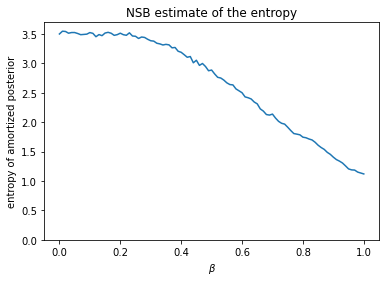

In [ ]:
# now do this over all values of phi
nsb_entropies = []
for phi in range(len(histograms_reshaped)):
    n = histograms_reshaped[phi, :]
    n_sum = np.sum(n)
    entropy_post_mean_per_alpha = []
    for alpha in alphas:
        a_sum = K * alpha
        
        second_term = 0
        for k in range(K):
            second_term += (n[k] + alpha) / (n_sum + a_sum) * digamma(n[k] + alpha + 1)
            
        entropy_post_mean_per_alpha.append( digamma(n_sum + a_sum + 1) - second_term )

    prior_alpha_normalized = prior_alpha_400 / np.sum(prior_alpha_400)
    nsb_entropy = entropy_post_mean_per_alpha @ prior_alpha_normalized
    
    nsb_entropies.append(nsb_entropy)

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, 1, len(nsb_entropies)), nsb_entropies)
ax.set(title='NSB estimate of the entropy', xlabel='$\\beta$', ylabel='entropy of amortized posterior')
ax.set(ylim=(0, 3.7))


[Text(0.5, 0, 'bin number'),
 Text(0, 0.5, 'probability'),
 Text(0.5, 1.0, 'posterior means of p')]

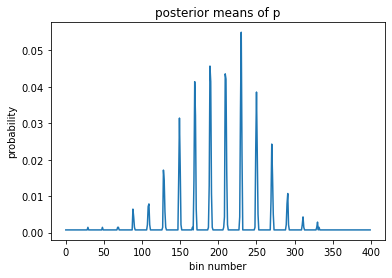

In [ ]:
# this gives us the posterior mean of the underlying parameter p of our categorical distribution. 
# we use a Dirichlet prior with alpha = 1, which is equivalent to a uniform prior over p. 
# the counts are the number of times each category was sampled, and serve as our observations.

from scipy.stats import dirichlet
alpha = np.ones(K)
counts = histograms_reshaped[0, :]

d = dirichlet(alpha=alpha+counts)
p = d.mean()
# print(p)
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(K), p)
ax.set(xlabel='bin number', ylabel='probability', title='posterior means of p')

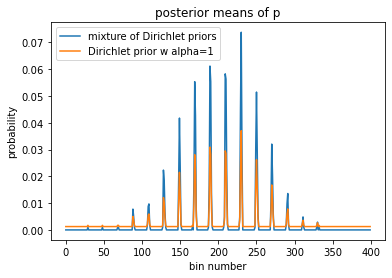

In [ ]:
# now we can also calculate the posterior mean using a mixture of Dirichlet priors. 

alphas = np.arange(0.02, 3.0, 0.2)
K = 400
prior_alpha = 1 / np.log(K) * (K * polygamma(1, K*alphas+1) - polygamma(1, alphas+1))  # this is unnormalized

posterior_p = 0
for a_idx, alpha in enumerate(alphas):
    d = dirichlet(alpha=alpha+counts)
    p = d.mean()
    posterior_p += p * prior_alpha[a_idx] / np.sum(prior_alpha)
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(K), posterior_p, label='mixture of Dirichlet priors')
ax.plot(np.arange(K), p, label='Dirichlet prior w alpha=1')
ax.set(xlabel='bin number', ylabel='probability', title='posterior means of p')
ax.legend()

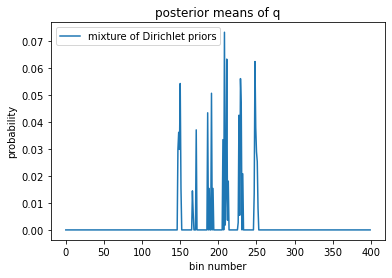

In [ ]:
# now do this for the q (prior) distribution as well

alphas = np.arange(0.02, 3.0, 0.2)
K = 400
prior_alphas = 1 / np.log(K) * (K * polygamma(1, K*alphas+1) - polygamma(1, alphas+1))  # this is unnormalized
prior_alphas_normalized = prior_alphas / np.sum(prior_alphas)

counts = prior_histograms[100].reshape(-1)

posterior_q = 0
for a_idx, alpha in enumerate(alphas):
    d = dirichlet(alpha=alpha+counts)
    q = d.mean()
    posterior_q += q * prior_alpha_normalized[a_idx]

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(K), posterior_q, label='mixture of Dirichlet priors')
ax.set(xlabel='bin number', ylabel='probability', title='posterior means of q')
ax.legend()

In [ ]:
# calculate the cross entropy between p and q for phi = 0
ce = -np.sum(posterior_p @ np.log(posterior_q))

kl_div = -nsb_entropies[0] + ce
print(kl_div)

2.90578661785982


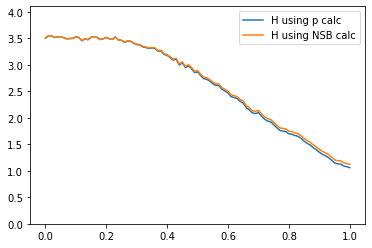

In [ ]:
# if we take the posterior mean of the p's, and then use those to calculate the entropy, what do we get?
alphas = np.arange(0.002, 3.0, 0.2)
K=400
prior_alphas = 1 / np.log(K) * (K * polygamma(1, K*alphas+1) - polygamma(1, alphas+1))  # this is unnormalized
prior_alphas_normalized = prior_alphas / np.sum(prior_alphas)

entropies_using_p_calc = []
for phi in range(len(histograms_reshaped)):
    counts = histograms_reshaped[phi, :]
    N = np.sum(counts)
    
    p_posterior_mean = []
    for a_idx, alpha in enumerate(alphas):
        d = dirichlet(alpha=alpha + counts)
        p_posterior_mean_per_alpha = d.mean()
        p_posterior_mean.append(p_posterior_mean_per_alpha)
    p_posterior_mean = np.stack(p_posterior_mean)
    
    alpha_posterior = p_posterior_mean.T @ prior_alphas_normalized
    
    # calculate the entropy using the posterior mean of p
    h = -np.sum(alpha_posterior * np.log(alpha_posterior))
    
    entropies_using_p_calc.append(h)

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, 1, len(h_per_phi)), entropies_using_p_calc, label='H using p calc')
ax.set(ylim=(0, 4.1))
ax.plot(np.linspace(0, 1, len(nsb_entropies)), nsb_entropies, label='H using NSB calc')
ax.legend()

nsb entropy calc done, onto the q calc
nsb entropy calc done, onto the q calc


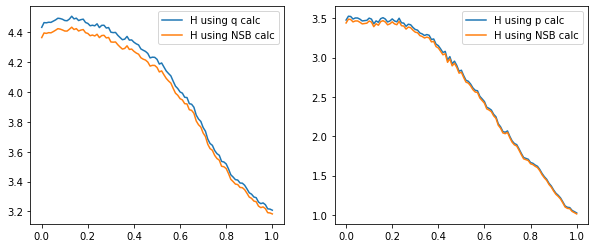

In [ ]:
def compare_nsb_and_p_calculations(counts_all_phis):
    # first calculate the hyperprior over alphas
    alphas = np.arange(0.00000000001, 3.1, 0.2)
    K=400
    prior_alphas = 1 / np.log(K) * (K * polygamma(1, K*alphas+1) - polygamma(1, alphas+1))  # this is unnormalized
    prior_alphas_normalized = prior_alphas / np.sum(prior_alphas)
    
    # NSB
    nsb_entropies_q = []
    for phi in range(len(counts_all_phis)):
        # n = histograms_reshaped[phi, :]
        n = counts_all_phis[phi, :]
        n_sum = np.sum(n)
        entropy_post_mean_per_alpha = []
        for alpha in alphas:
            a_sum = K * alpha
            
            second_term = 0
            for k in range(K):
                second_term += (n[k] + alpha) / (n_sum + a_sum) * digamma(n[k] + alpha + 1)
                
            entropy_post_mean_per_alpha.append( digamma(n_sum + a_sum + 1) - second_term )

        nsb_entropy = entropy_post_mean_per_alpha @ prior_alphas_normalized
        
        nsb_entropies_q.append(nsb_entropy)

    print('nsb entropy calc done, onto the q calc')

    # then using the posterior mean of q
    entropies_using_q_calc = []
    for phi in range(len(counts_all_phis)):
        # n = histograms_reshaped[phi, :]
        n = counts_all_phis[phi, :]
        
        N = np.sum(n)
        
        p_posterior_mean = []
        for a_idx, alpha in enumerate(alphas):
            d = dirichlet(alpha=alpha + n)
            p_posterior_mean_per_alpha = d.mean()
            p_posterior_mean.append(p_posterior_mean_per_alpha)
        p_posterior_mean = np.stack(p_posterior_mean)
        
        alpha_posterior = p_posterior_mean.T @ prior_alphas_normalized
        
        # calculate the entropy using the posterior mean of p
        h = -np.sum(alpha_posterior * np.log(alpha_posterior))
        
        entropies_using_q_calc.append(h)
        
    return nsb_entropies_q, entropies_using_q_calc

counts_all_phis = prior_histograms.reshape(101, -1)
nsb_entropies_q, entropies_using_q_calc = compare_nsb_and_p_calculations(counts_all_phis)

counts_all_phis = histograms_reshaped
nsb_entropies_p, entropies_using_p_calc = compare_nsb_and_p_calculations(counts_all_phis)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(np.linspace(0, 1, len(h_per_phi)), entropies_using_q_calc, label='H using q calc')
# ax[0].set(ylim=(0, 4.1))
ax[0].plot(np.linspace(0, 1, len(nsb_entropies)), nsb_entropies_q, label='H using NSB calc')
ax[0].legend()

ax[1].plot(np.linspace(0, 1, len(h_per_phi)), entropies_using_p_calc, label='H using p calc')
ax[1].plot(np.linspace(0, 1, len(nsb_entropies)), nsb_entropies_p, label='H using NSB calc')
ax[1].legend()

[Text(0.5, 1.0, 'KL divergence')]

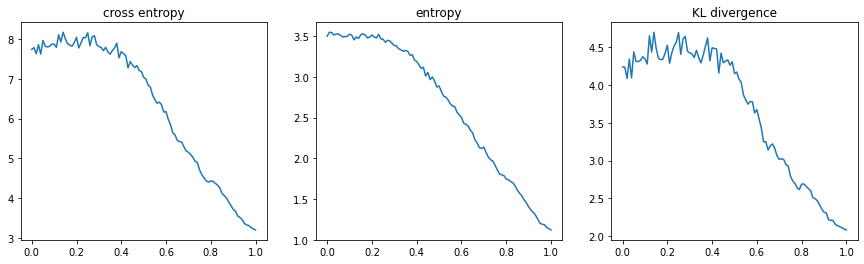

In [ ]:
# cross-entropy using the posterior mean of p and q (rather than the true p and q)
alphas = np.arange(0.00000000001, 3.1, 0.2)
K=400
prior_alphas = 1 / np.log(K) * (K * polygamma(1, K*alphas+1) - polygamma(1, alphas+1))  # this is unnormalized
prior_alphas_normalized = prior_alphas / np.sum(prior_alphas)

counts_all_phis_p = histograms_reshaped
counts_all_phis_q = prior_histograms.reshape(101, -1)

# then using the posterior mean of q
entropies_using_pq_calc = []
for phi in range(len(counts_all_phis_p)):
    # n = histograms_reshaped[phi, :]
    n_p = counts_all_phis_p[phi, :]
    n_q = counts_all_phis_q[100, :]
    
    N = np.sum(n)
    
    p_posterior_mean = []
    q100_posterior_mean = []
    for a_idx, alpha in enumerate(alphas):
        d_p = dirichlet(alpha=alpha + n_p)
        d_q100 = dirichlet(alpha=alpha + n_q)
        
        p_posterior_mean_per_alpha = d_p.mean()
        q100_posterior_mean_per_alpha = d_q100.mean()
        
        p_posterior_mean.append(p_posterior_mean_per_alpha)
        q100_posterior_mean.append(q100_posterior_mean_per_alpha)
    p_posterior_mean = np.stack(p_posterior_mean)
    q100_posterior_mean = np.stack(q100_posterior_mean)
    
    alpha_posterior_p = p_posterior_mean.T @ prior_alphas_normalized
    alpha_posterior_q100 = q100_posterior_mean.T @ prior_alphas_normalized
    
    # calculate the entropy using the posterior mean of p
    ce = -np.sum(alpha_posterior_p * np.log(alpha_posterior_q100))
    
    entropies_using_pq_calc.append(ce)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(np.linspace(0, 1, len(h_per_phi)), entropies_using_pq_calc)
ax[0].set(title='cross entropy')
ax[1].plot(np.linspace(0, 1, len(h_per_phi)), nsb_entropies)
ax[1].set(title='entropy')

# now calculate the KL divergence using this CE estimate and the true measure of H
kl = []
for phi in range(len(counts_all_phis_p)):
    kl.append(entropies_using_pq_calc[phi] - nsb_entropies[phi])
    

ax[2].plot(np.linspace(0, 1, len(h_per_phi)), kl)
ax[2].set(title='KL divergence')

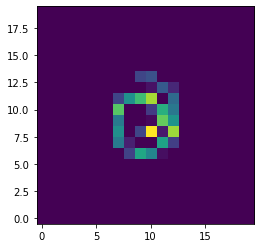

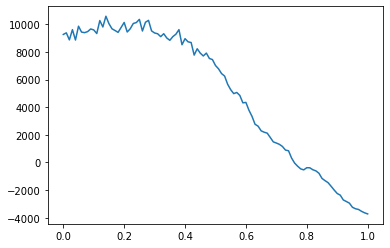

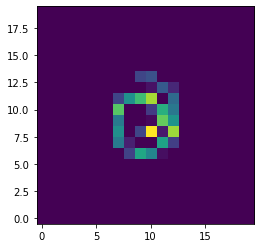

In [ ]:
# to calculate the KL divergence, we need to calculate the cross entropy between the amortized posterior and the prior (p and q)
# here we take 0log0 = 0 by convention
from scipy.special import xlogy

phi = 0
epsilon = 1e-10
q = prior_histograms[100].reshape(-1) + epsilon

cross_entropies = []
for phi in range(101):
    p = histograms[phi].reshape(-1)
    cross_entropy = -np.sum(xlogy(p, q))
    cross_entropies.append(cross_entropy)

fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, 1, len(cross_entropies)), cross_entropies)

fig, ax = plt.subplots(1, 1)
ax.imshow(q.reshape(20, 20).T, origin='lower')


let's think about what this means. $p(x \mid \beta=0)$ is at the start of the reverse process, when the distribution is the most "diffuse". 
This is when the effect of the likelihood score $\nabla_{x_t} \log p(s \mid x)$ is relatively strong compared to the effect of the prior score $\nabla_{x_t} \log p(x)$. 

Conversely, $p(x \mid \beta=1)$ is when the samples are close to the posterior $p(x \mid s)$. At this point we see empirically that the effect of the prior is strong relative to the effect of the likelihood. 

We think the likelihood score dominates at the start, before it's drowned out by relative contribution of the prior score. Not sure what we should expect to see with the KL divergence in this case. 

But really I think KL divergence is the wrong thing to calculate, because:

- $p(x \mid \beta = 0) = p(x_0)$ but is NOT $\approx p(s \mid x)$
- $p(x \mid \beta = 1) = p(x_{100}) \approx p(x \mid s)$

What we got confused about is that the *flow field* of $p(x \mid \beta)$ is similar to the *flow field* of $p(s \mid x)$, but not the two distributions. This means we should be calculating a distance metric between the flow fields, rather than the distributions.

So either we calculate the cosine similarity at multiple points, or we calculate the difference in the vectors. 


In [ ]:
# let's take a look at the flow fields again at different temperatures

# the posterior
from likelihood_utils import compute_diffuser_score
from generate_data import load_trimodal_data
dataset = data_roll_gt

# display the flow field for the prior sampler 
lim = 2
score_lim = lim
lims = [-lim, lim]
num_samples = 25

# temps = torch.tensor([[0], [20], [50], [100]], dtype=torch.float)  # lim=2
temps = torch.arange(0, 110, 10).reshape(-1, 1)
# temps = torch.tensor([[0], [1], [2], [5]], dtype=torch.float)  # lim=2

print(temps.detach().numpy().T.reshape(-1).astype(int))


score_temps = []
for t in temps:
    score_xs = []
    score_ys = []
    for sample_y in np.linspace(-lim, lim, num_samples):
        for sample_x in np.linspace(-lim, lim, num_samples):
            
            # compute the score 
            x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
            diffuser_score = compute_diffuser_score(prior_sampler, x, t=t/100).detach()
            
            likelihood_score = compute_occlusion_score(x, Mm, sigma=0.2)
            
            # posterior_score = -diffuser_score + 0.5*likelihood_score
            posterior_score = -diffuser_score
            # posterior_score = 0.5 * likelihood_score
            
            score_x, score_y = posterior_score[0,0], posterior_score[0,1]
            
            # collect data
            score_xs.append(score_x)
            score_ys.append(score_y)
    score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
    score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)

    score_temps.append(torch.stack((score_xs, score_ys), dim=2))
    color = np.hypot(score_xs, score_ys)**2
score_temps = torch.stack(score_temps)
print(score_temps.shape)

[  0  10  20  30  40  50  60  70  80  90 100]
torch.Size([11, 25, 25, 2])


torch.Size([25, 25, 2])


[Text(0.5, 0, 'temperature'),
 Text(0, 0.5, 'avg cosine similarity'),
 Text(0.5, 1.0, 'avg cosine similarity to flow field at t=1')]

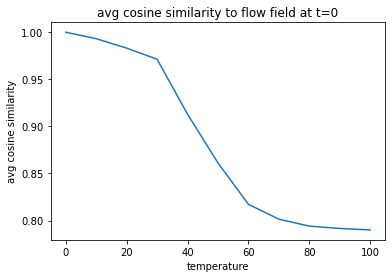

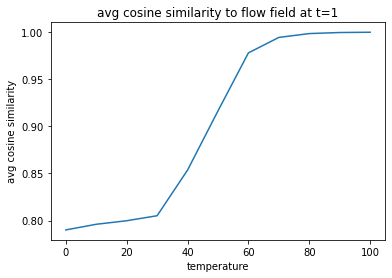

In [ ]:
# okay so let's now calculate the cosyne similarity between the flow fields
# at different temperatures

# flow field at t=0
score_0 = score_temps[0, :, :, :]
print(score_0.shape)
score_1 = score_temps[1, :, :, :]

# compute the cosine similarity
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def calculate_avg_cos_sim_between_two_flow_fields(score_0, score_1):
    cosine_sim = []
    for i in range(score_0.shape[0]):
        for j in range(score_0.shape[1]):
            cosine_sim.append(cosine(score_0[i,j,:], score_1[i,j,:]))
    # cosine_sim = np.stack(cosine_sim).reshape(score_0.shape[0], score_0.shape[1])
    cosine_sim = np.stack(cosine_sim).mean()
    return cosine_sim

avg_cos_sims_vs_0_posterior = []
for t in range(len(score_temps)):
    # print(f'avg cosine similarity between t=0 and t={temps[t].item()}:')
    avg_cos_sim = calculate_avg_cos_sim_between_two_flow_fields(score_temps[0, :, :, :], score_temps[t, :, :, :])
    # print(avg_cos_sim)
    avg_cos_sims_vs_0_posterior.append(avg_cos_sim)
    
# plot the avg cosine similarity between t=0 (llh flow field) and t=t
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_0_posterior)
ax.set(xlabel='temperature', ylabel='avg cosine similarity', title='avg cosine similarity to flow field at t=0')


avg_cos_sims_vs_1_posterior = []
for t in range(len(score_temps)):
    # print(f'avg cosine similarity between t=1 and t={temps[t].item()}:')
    avg_cos_sim = calculate_avg_cos_sim_between_two_flow_fields(score_temps[10, :, :, :], score_temps[t, :, :, :])
    # print(avg_cos_sim)
    avg_cos_sims_vs_1_posterior.append(avg_cos_sim)
    
# plot the avg cosine similarity between t=1 (posterior flow field) and t=t
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_1_posterior)
ax.set(xlabel='temperature', ylabel='avg cosine similarity', title='avg cosine similarity to flow field at t=1')


### comparison against prior diffusion
And as a point of comparison, let's compare this against avg cosine similarity measures of prior-only flow fields. 

In [ ]:
from likelihood_utils import compute_diffuser_score
from generate_data import load_trimodal_data
dataset = data_roll_gt

# display the flow field for the prior sampler 
lim = 1.5
score_lim = lim
num_samples = 25

t = torch.tensor([0])
temps = torch.arange(0, 110, 10).reshape(-1, 1)
print(temps.detach().numpy().T.reshape(-1).astype(int))

x_hyps = []
for i in np.linspace(-score_lim, score_lim, 11):
    x_hyp = np.linspace(start=[-i, score_lim], stop=[-i, -score_lim], num=15)
    x_hyps.append(x_hyp)
x_hyps = np.vstack(x_hyps)
x_hyps = torch.tensor(x_hyps, dtype=torch.float)


score_temps = []
for t in temps:
    score_xs = []
    score_ys = []
    for sample_y in np.linspace(-lim, lim, num_samples):
        for sample_x in np.linspace(-lim, lim, num_samples):
            
            # compute the score 
            x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
            diffuser_score = compute_diffuser_score(prior_sampler, x, t=t).detach()
            
            score_x, score_y = -diffuser_score[0,0], -diffuser_score[0,1]
            
            # collect data
            score_xs.append(score_x)
            score_ys.append(score_y)
    score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
    score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)
    
    score_temps.append(torch.stack((score_xs, score_ys), dim=2))
    color = np.hypot(score_xs, score_ys)**2
score_temps = torch.stack(score_temps)
print(score_temps.shape)

[  0  10  20  30  40  50  60  70  80  90 100]
torch.Size([11, 25, 25, 2])


[Text(0.5, 0, 'temperature'),
 Text(0, 0.5, 'avg cosine similarity'),
 Text(0.5, 1.0, 'avg cosine similarity to flow field at t=1')]

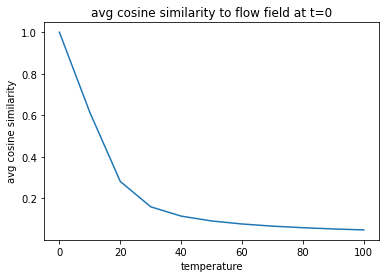

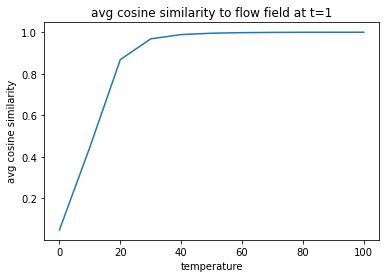

In [ ]:
avg_cos_sims_vs_0_prior = []
for t in range(len(score_temps)):
    # print(f'avg cosine similarity between t=0 and t={temps[t].item()}:')
    avg_cos_sim = calculate_avg_cos_sim_between_two_flow_fields(score_temps[0, :, :, :], score_temps[t, :, :, :])
    # print(avg_cos_sim)
    avg_cos_sims_vs_0_prior.append(avg_cos_sim)
    
# plot the avg cosine similarity between t=0 (llh flow field) and t=t
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_0_prior)
ax.set(xlabel='temperature', ylabel='avg cosine similarity', title='avg cosine similarity to flow field at t=0')


avg_cos_sims_vs_1_prior = []
for t in range(len(score_temps)):
    # print(f'avg cosine similarity between t=1 and t={temps[t].item()}:')
    avg_cos_sim = calculate_avg_cos_sim_between_two_flow_fields(score_temps[10, :, :, :], score_temps[t, :, :, :])
    # print(avg_cos_sim)
    avg_cos_sims_vs_1_prior.append(avg_cos_sim)
    
# plot the avg cosine similarity between t=1 (posterior flow field) and t=t
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_1_prior)
ax.set(xlabel='temperature', ylabel='avg cosine similarity', title='avg cosine similarity to flow field at t=1')


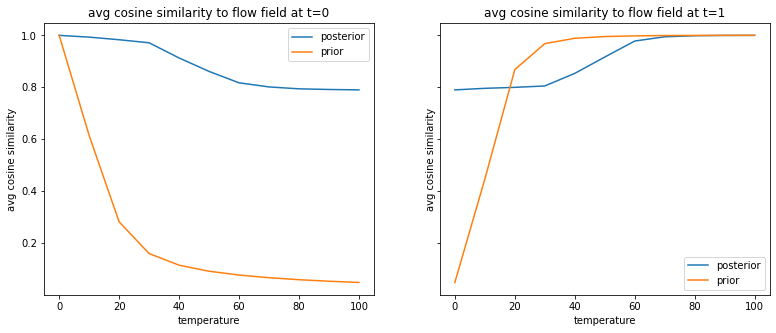

In [ ]:
# comparison of the similarity distances for the prior and posterior flow fields

fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
ax[0].plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_0_posterior, label='posterior')
ax[0].plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_0_prior, label='prior')
ax[0].set(xlabel='temperature', ylabel='avg cosine similarity', title='avg cosine similarity to flow field at t=0')
ax[0].legend()

ax[1].plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_1_posterior, label='posterior')
ax[1].plot(temps.detach().numpy().T.reshape(-1), avg_cos_sims_vs_1_prior, label='prior')
ax[1].set(xlabel='temperature', ylabel='avg cosine similarity', title='avg cosine similarity to flow field at t=1')
ax[1].legend()